# Conductance-based Spiking Neural Network (conductance-SNN)

The following code simulates a Coördinated Spiking Model with $\textit{N}$ neurons and a one-dimensional input. The model contains the following functions:

- initialize_params: initialize the variables and parameters for simulating the network
- time_varying_signal: creates input signal
- run: runs the spiking network model
- visualize: plots the results (input + input estimate, spike trains and voltages)

In addition, other functions have been added to plot the parameters of the network.

## Install required packages

In [1]:
import numpy as np
import pylab as pl
import random
from scipy.signal import sweep_poly
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.animation as animation
import copy
import math

## Functions used for simulation

### Initialize parameters

Initialize parameters

In [2]:
def initialize_params(N, dt, iterations, gamma, weights='homogeneous'):
    """ Initialize parameters. """

    t = np.arange(0, iterations) * dt                    # time
    x_est = np.zeros(iterations)                         # input estimate
    
    o = np.zeros((N, iterations))                        # spike trains
    voltage = np.zeros((N, iterations))                  # voltages
    
    D = np.ones(N)                                       # ''output kernel''
    if weights == 'homogeneous':
        D *= gamma
    elif weights == 'heterogeneous':
        D = np.random.normal(1/N, 0.5, size=(N))
    
    T = [(weight ** 2)/2 for weight in D]                # threshold

    return (t, x_est, o, voltage, D, T) 

### Time varying signal

Create time varying signal

In [3]:
def time_varying_signal(c_upp=3):
    """ Initialize time varying input signal. """

    # create time-varying signal
    x = c_upp
    x_t = np.ones(iterations) * x

    step = 150
    x_t[0:step] = 0
    x_t[iterations - 2 * step:iterations] = 0

    x = gaussian_filter1d(x_t, sigma=20) # smooth signal

    dxdt = np.diff(x)/dt
    c = x[:-1] + dxdt
    
    return (x, c)

### Run simulation

For the simulation, one uses the Euler method using the following derivative equations:

- $\dot{\hat{x}} = -\hat{x} + \sum^{N}_{k = 1} D_{k} s_{k}$
- $\lambda \dot{V}_{i} = (\frac{x}{\tau} + \dot{x}) (1 - V_{i}) + \sum^{N}_{k = 1} (D_{ik} s_{k}) (-1 - V_{i})$


In [4]:
def run(rho, E_e=1, E_i=-1, lambda_constant='F', var=0):
    """ Run simulation of spike coding network. """
    lambda_val = 0
    
    for t in range(1, iterations):

        # update input estimate
        dxestdt = -x_est[t - 1] + np.dot(D, o[:, t - 1])
        x_est[t] = x_est[t - 1] + dt * dxestdt 

        # update voltages
        if lambda_constant == 'F':
            lambda_val = 1/(x[t - 1] + x_est[t - 1] + rho)
        else:
            lambda_val = 1/var

        dVdt =  lambda_val * (c[t - 1] * (E_e - voltage[:, t - 1]) + \
                              np.dot(D, o[:, t - 1]) * (E_i - voltage[:, t - 1]))
        voltage[:, t] = voltage[:, t - 1] + dt * dVdt

        # check for neurons with voltages above threshold
        neurons = np.arange(0, N, 1)
        above_threshold = []
        above_threshold = neurons[np.where(voltage[:, t] > T)]
            
        # reset neuron when threshold is exceeded
        if len(above_threshold) > 0:

            # select random neuron who's voltage is above threshold
            spike_neuron = np.random.choice(above_threshold)

            # update spikes
            o[spike_neuron, t] = 1/dt

### Visualize results

Functions used to visualize results

In [5]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    
    return [float('nan') if x==0 else x for x in values]

In [6]:
def visualize(color, plot_voltage=1):
    """ Visualize results of the simulation of the spike coding network. """ 
    
    if plot_voltage == 0:
        plots = 2
    else:
        plots = N + 2
    pl.subplots(plots, 1, figsize=(8, 10))
    pl.subplots_adjust(hspace=0.7)
    pl.rc('text', usetex=True)

    # plot input and input estimate
    pl.subplot(plots, 1, 1)
    pl.title('Input and input estimate')
    pl.xlim(0, iterations * dt)
    pl.xticks([0, iterations * dt])
    
    pl.plot(t, x, label=r'$x$', color='black')
    pl.plot(t, x_est, label=r'$\hat{x}$', color='gray')
    pl.plot(t[:-1], c, '--k', label=r'$x + \dot{x}$', alpha=0.2)
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # plot spike trains
    pl.subplot(plots, 1, 2)
    pl.xlim(0, iterations * dt)
    pl.xticks([0, iterations * dt])
    for i in range(1, N + 1):
        values = zero_to_nan(o[i - 1, :] * i)   
        pl.scatter(t, values, color=color[i - 1][:]/255, label='N%i' %i)
        pl.title('Spike train')
        
    # Put a legend to the right of the current axis
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    counter = 3
    
    if plot_voltage == 1:
        # plot voltage over time
        for i in range(1, N + 1):
            pl.subplot(plots, 1, counter)
            
            pl.plot(t, voltage[i - 1, :], color=color[i - 1][:]/255, label='N%i'%i)
            pl.plot(t, np.ones(iterations) * T[i - 1], color='gray', label='threshold')                
            pl.plot(t, np.ones(iterations) * E_e, '--r', alpha=0.5, label='Reversal potential E')
            pl.plot(t, np.ones(iterations) * E_i, '--b', alpha=0.5, label='Reversal potential I')
            
            pl.title('Neuron %i' %i)
            pl.ylabel('Voltage')
            pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            counter = counter + 1
            pl.xlim(0, iterations * dt)
            pl.xticks([0, iterations * dt])

## Functions used to visualize additional data

### Membrane voltage

Compute voltage estimate one of two ways:

1) Computed voltage estimate using the derivative $\frac{dV_{i}}{dt} = (\frac{x}{\tau} + \dot{x}) (E_{E} - V_{i}) \frac{1}{\lambda} + \sum^{N}_{k = 1} (D_{ik} s_{k}) (-1 - V_{i}) \frac{1}{\lambda}$ where $\lambda = (x + \hat{x} + \rho)$

2) Compute voltage estimate using a linear readout applied to the spike trains $V_{i} = \frac{D_{i}(x - \hat{x})}{D_{i}(x + \hat{x} + \rho)}$

In [14]:
def visualize_voltage(rho):
    """ Compute and visualize membrane voltage of each neuron. Returns offline voltage. """
    
    # compute voltage (by method 2)
    voltage2 = np.zeros((N, iterations))
    for i in range(N):
        voltage2[i, :] = (D[i] * (x - x_est)) / (D[i] * (x + x_est + rho))

    # plot voltages
    counter = 1
    pl.subplots(N, 2, figsize=(14, 4))
    # pl.suptitle('Voltage', fontsize=15)
    for i in range(1, N+1):
        pl.subplot(N, 2, counter)
        if counter == 1:
            pl.title(r'Online $\frac{dV_{i}}{dt} =  \frac{1}{\lambda}((\frac{x}{\tau} + \dot{x}) (1 - V_{i}) + \sum^{N}_{k = 1} (D_{ik} s_{k}) (-1 - V_{i}))$',  fontsize=20)
        counter = counter + 1
        pl.plot(t, voltage[i - 1, :], color=color[i - 1][:]/255, label='N%i' %i)
        pl.ylabel('voltage')
        pl.xlabel('time')
        pl.subplot(N, 2, counter)
        if counter == 2:
            pl.title(r'Offline $V_{i} = \frac{D_{i}(x - \hat{x})}{D_{i}(x + \hat{x} + \rho)}$', fontsize=20)
        counter = counter + 1
        pl.plot(t, voltage2[i - 1, :], color=color[i - 1][:]/255, label='N%i' %i)
        pl.xlabel('time')
        pl.legend()
        
        return voltage2

## Run simulation

### $\textit{N}$-neurons (homogeneous network)

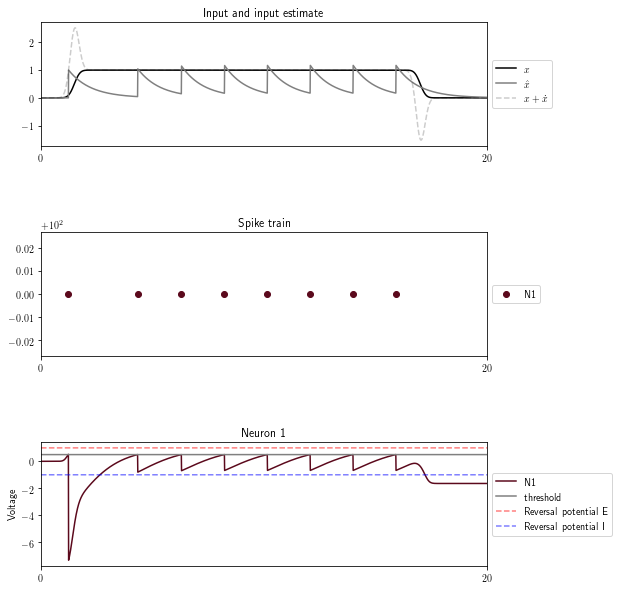

In [12]:
N = 1
dt = 0.01
iterations = 2000
c_upp = 1
beta = 0
gamma = 1
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors
E_e = 1                                                  # excitatory reversal potential
E_i = -1                                                 # inhibitory reversal potential
rho = 0.1

t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 

run(rho=rho, E_e=E_e, E_i=E_i)
visualize(color)

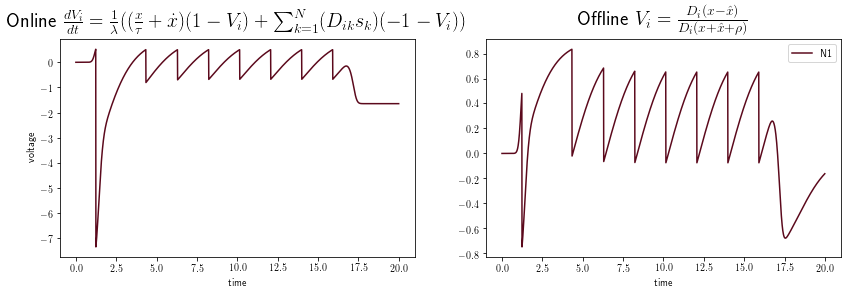

In [15]:
voltage2 = visualize_voltage(rho)

## Visualize voltage for comparing parameter manipulation

In [113]:
def visualize_multi(counter, num, color, plot_voltage=1, var=0):
    """ Visualize results of the simulation of the spike coding network. This functions runs multiple simulations. """ 

    # plot input and input estimate
    pl.subplot(plots, num, counter)
    counter += 2

    pl.plot(t, x, label=r'$x$', color='black')
    pl.plot(t, x_est, label=r'$\hat{x}$', color='gray')
    pl.plot(t[:-1], c, '--k', label=r'$x + \dot{x}$', alpha=0.2)
    
    if var == 0:
        pl.title('Input and input estimate')
    else:
        pl.title(r'$\lambda = %.1f$' %var, fontsize=15)
    pl.xlim(0, iterations * dt)
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # plot spike trains
    pl.subplot(plots, num, counter)
    counter += 2

    for i in range(1, N + 1):
        values = zero_to_nan(o[i - 1, :] * i)
        pl.scatter(t, values, color=color[i - 1][:]/255, label='N%i' %i)

    pl.title('Spike train')
    pl.xlim(0, iterations * dt)
    pl.ylim(0, 100 * N + 100)
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    if plot_voltage == 1:
        for i in range(1, N + 1):
            pl.subplot(plots, num, counter)
            counter += 2

            pl.plot(t, voltage[i - 1, :], color=color[i - 1][:]/255, label='N%i'%i)
            pl.plot(t, np.ones(iterations) * T[i - 1], color='gray', label='threshold')
            pl.plot(t, np.ones(iterations) * E_e, '--r', alpha=0.5, label='Reversal potential E')
            pl.plot(t, np.ones(iterations) * E_i, '--b', alpha=0.5, label='Reversal potential I')

            pl.xlim(0, iterations * dt)
            #pl.ylim(limits[1][0], limits[1][1])
            pl.ylabel('Voltage')
            pl.title('Neuron %i' %i)
            pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Varying external input

In [99]:
N = 1
dt = 0.01
iterations = 2000
gamma = 1
beta = 0.0                                               # cost
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors
E_e = 4                                                  # excitatory reversal potential
E_i = -1                                                 # inhibitory reversal potential
var = 1
lambda_constant ='F'

0.9768323357376141
0.9977345874807018


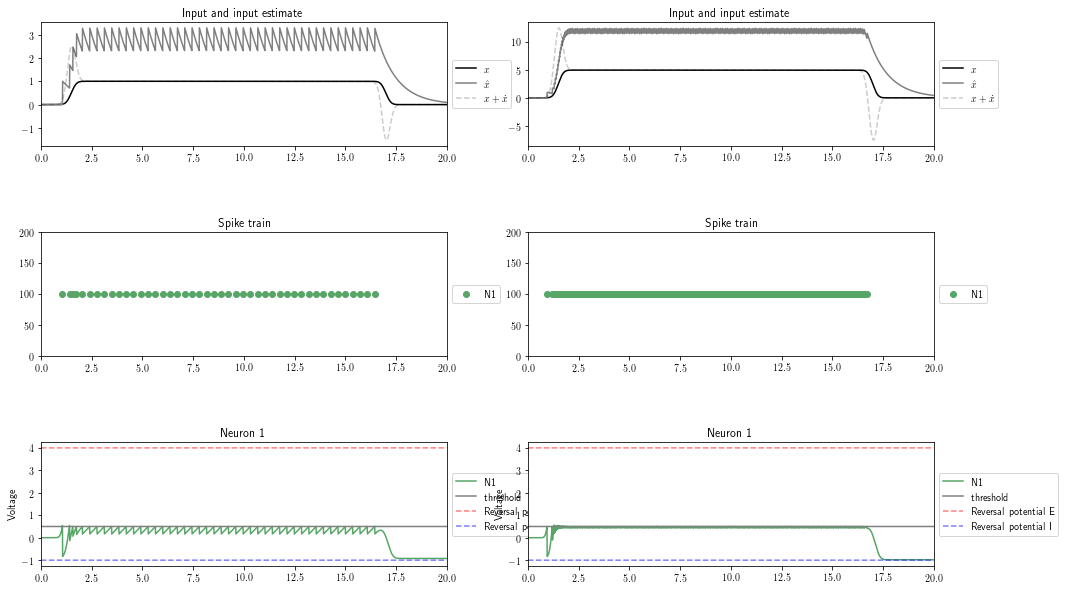

In [100]:
# initiate plots
plots = N + 2
num = 2
pl.subplots(plots, num, figsize=(16, 10))
pl.subplots_adjust(hspace=0.7)
pl.rc('text', usetex=True)

# initiate counter
counter = 1

# sim 1
c_upp = 1
t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 
run(rho=rho, E_e=E_e, E_i=E_i, lambda_constant=lambda_constant, var=var)
visualize_multi(counter, num, color)
counter += 1
x_est1 = copy.copy(x_est)

# sim 2
c_upp = 5
t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 
run(rho=rho, E_e=E_e, E_i=E_i, lambda_constant=lambda_constant, var=var)
visualize_multi(counter, num, color)
counter += 1
x_est2 = copy.copy(x_est)

print(max(x_est1[1000:1200]) - min(x_est1[1000:1200]))
print(max(x_est2[1000:1200]) - min(x_est2[1000:1200]))

## Varying $\lambda$

$\lambda \dot{V}_{i} = (\frac{x}{\tau} + \dot{x}) (1 - V_{i}) + \sum^{N}_{k = 1} (D_{ik} s_{k}) (-1 - V_{i})$

In [398]:
N = 1
dt = 0.01
iterations = 2000
c_upp = 1
gamma = 1
beta = 0.0                                               # cost
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors
E_e = 1                                                  # excitatory reversal potential
E_i = -1                                                 # inhibitory reversal potential

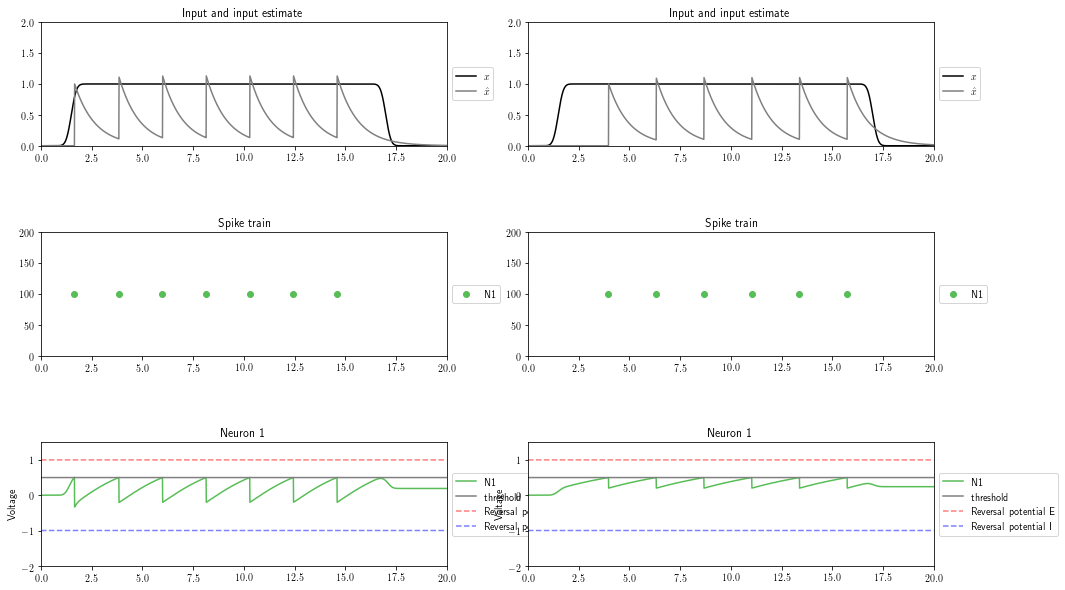

In [399]:
# initiate plots
plots = N + 2
num = 2
pl.subplots(plots, num, figsize=(16, 10))
pl.subplots_adjust(hspace=0.7)
pl.rc('text', usetex=True)

# initiate counter
counter = 1

# limits y-axis
limits = np.array([[0, 2],[-2, 1.5]])

# sim 1
lambda_constant = 'T'
var = 0.7
t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 
run(rho=rho, E_e=E_e, E_i=E_i)
visualize_multi(counter, num, limits, color)
counter += 1

# sim 2
lambda_constant = 'T'
var = 5
t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 
run(rho=rho, E_e=E_e, E_i=E_i, lambda_constant=lambda_constant, var=var)
visualize_multi(counter, num, limits, color)
counter += 1

## Varying excitatory reversal potential I

### 1. Excitatory reversal potential

In [400]:
N = 1
dt = 0.01
iterations = 2000
c_upp = 1
gamma = 1
beta = 0.0                                               # cost
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors
E_i = -1
var = 0

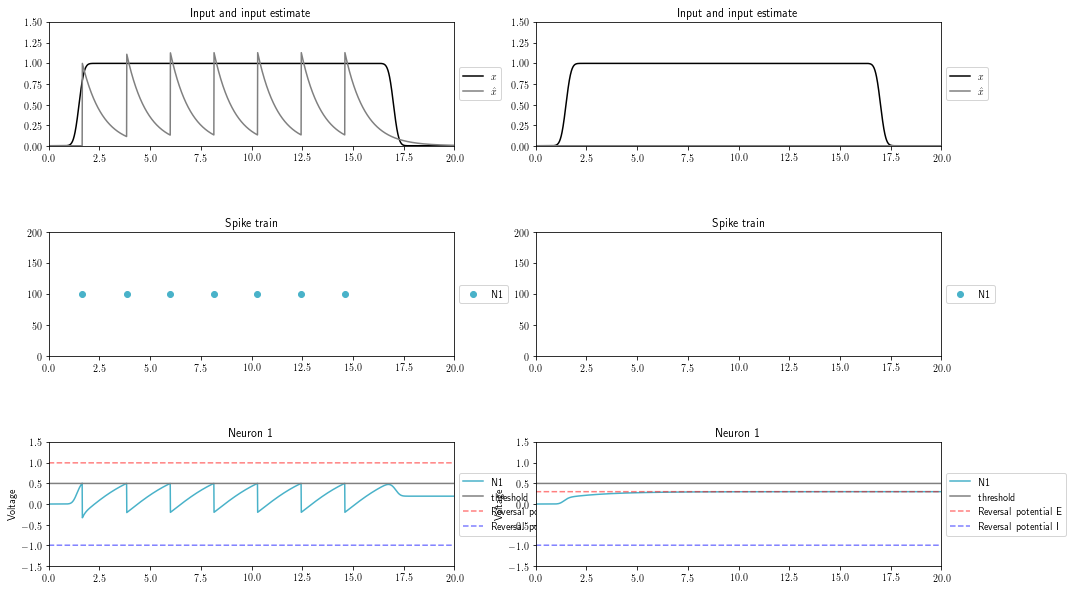

In [401]:
# initiate plots
plots = N + 2
num = 2
pl.subplots(plots, num, figsize=(16, 10))
pl.subplots_adjust(hspace=0.7)
pl.rc('text', usetex=True)

# initiate counter
counter = 1

# limits y-axis
limits = np.array([[0, 1.5],[-1.5, 1.5]])

# sim 1
E_e = 1 
t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 
run(rho=rho, E_e=E_e, E_i=E_i)
visualize_multi(counter, num, limits, color)
counter += 1

# sim 2
E_e = 0.3 
t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 
run(rho=rho, E_e=E_e, E_i=E_i)
visualize_multi(counter, num, limits, color)

## Varying reversal potential II

### 1. Excitatory reversal potential

In [402]:
N = 1
dt = 0.01
iterations = 2000
c_upp = 1
gamma = 1
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors
E_i = -1

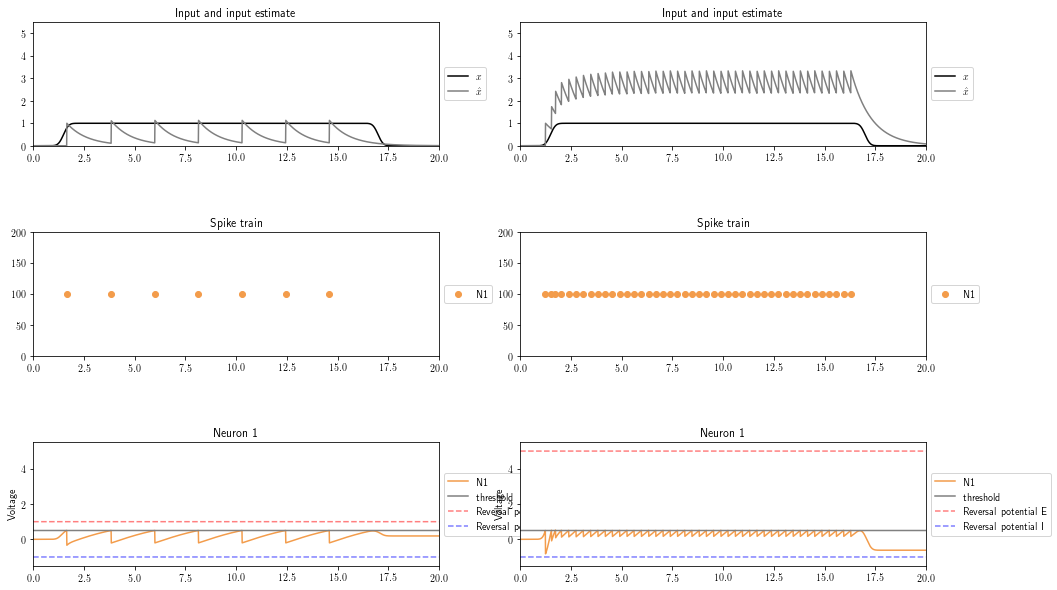

In [403]:
# initiate plots
plots = N + 2
num = 2
pl.subplots(plots, num, figsize=(16, 10))
pl.subplots_adjust(hspace=0.7)

spike_num = []
E_e_values = [1, 5]

# initiate counter
counter = 1

# limits y-axis
limits = np.array([[0, 5.5],[-1.5, 5.5]])

# sim 1
E_e = E_e_values[0]
t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 
run(rho=rho, E_e=E_e, E_i=E_i)
spike_num.append(sum(o[0, :])/100)
visualize_multi(counter, num, limits, color)
counter += 1

# sim 2
E_e = E_e_values[1]
t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 
run(rho=rho, E_e=E_e, E_i=E_i)
spike_num.append(sum(o[0, :])/100)
visualize_multi(counter, num, limits, color)
counter += 1

([<matplotlib.axis.XTick at 0x224bfe26c50>,
 <a list of 2 Text xticklabel objects>)

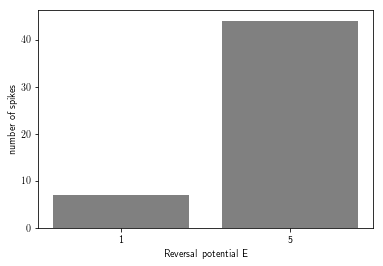

In [404]:
# plot number of spikes
pl.figure()
pl.ylabel('number of spikes')
bars = ('%i'%E_e_values[0], '%i'%E_e_values[1])
pl.bar(np.arange(len(bars)), spike_num, color='gray')
pl.xlabel('Reversal potential E')
pl.xticks(np.arange(len(bars)), bars)

### 2. Inhibitory reversal potential

In [405]:
N = 1
dt = 0.01
iterations = 2000
c_upp = 1
gamma = 1
beta = 0.0                                               # cost
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors
E_e = 1

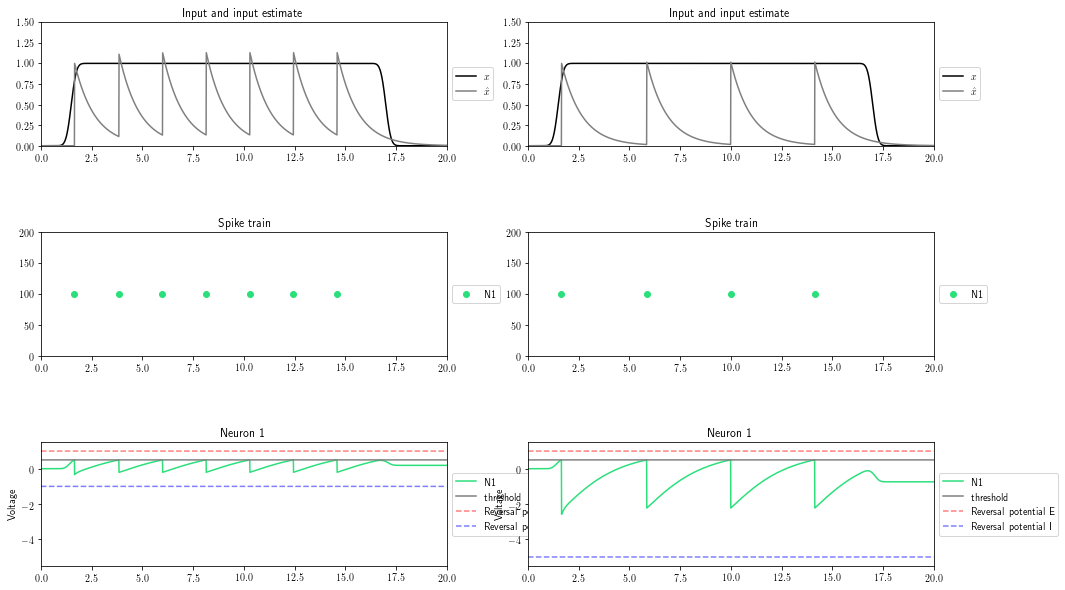

In [406]:
# initiate plots
plots = N + 2
num = 2
pl.subplots(plots, num, figsize=(16, 10))
pl.subplots_adjust(hspace=0.7)

spike_num = []
E_i_values = [-1, -5]

# initiate counter
counter = 1

# limits y-axis
limits = np.array([[0, 1.5],[-5.5, 1.5]])

# sim 1
E_i = E_i_values[0]
t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 
run(rho=rho, E_e=E_e, E_i=E_i)
spike_num.append(sum(o[0, :])/100)
visualize_multi(counter, num, limits, color)
counter += 1

# sim 2
E_i = E_i_values[1]
t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 
run(rho=rho, E_e=E_e, E_i=E_i)
spike_num.append(sum(o[0, :])/100)
visualize_multi(counter, num, limits, color)
counter += 1

([<matplotlib.axis.XTick at 0x224be2b97b8>,
 <a list of 2 Text xticklabel objects>)

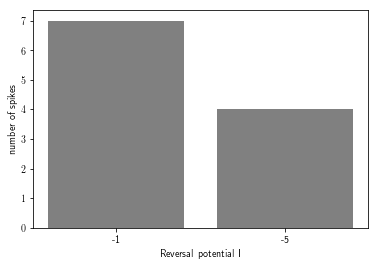

In [407]:
# plot number of spikes
pl.figure()
pl.ylabel('number of spikes')
bars = ('%i'%E_i_values[0], '%i'%E_i_values[1])
pl.bar(np.arange(len(bars)), spike_num, color='gray')
pl.xlabel('Reversal potential I')
pl.xticks(np.arange(len(bars)), bars)